In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000) ## 800GB?

from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns

import branca
import folium
import shared_utils

from siuba import *
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_columns', None) 

from calitp import get_engine

engine = get_engine()
connection = engine.connect()

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


# Correlation and VIF in Analytical File

In [2]:
GCS_FILE_PATH = 'gs://calitp-analytics-data/data-analyses/ahsc_grant/'

In [3]:
# start with trips per stop and ridership
analysis_tbl = gpd.read_parquet(f"{GCS_FILE_PATH}analytical_tbl.parquet")
analysis_tbl >> head (5)

,calitp_itp_id,stop_id,geometry,stop_name,n_trips_ampeak,n_trips_midday,n_trips_pmpeak,n_trips_earlyam,n_trips_latepm,n_trips_sat,n_trips_sun,n_trips_weekday,sat_ons,sun_ons,weekday_ons,dropna,sum_tracts,sum_total_pop,sum_households,sum_not_us_citizen_pop,sum_black_pop,sum_hispanic_pop,sum_youth_pop,sum_seniors_pop,sum_inc_extremelylow,sum_inc_verylow,sum_inc_low,sum_pop_determined_poverty_status,sum_poverty,sum_no_car,sum_no_cars,sum_land_area,sum_jobs,pop_density,job_density,pct_not_us_citizen_pop,pct_black_pop,pct_hispanic_pop,pct_youth_pop,pct_seniors_pop,pct_inc_extremelylow,pct_inc_verylow,pct_inc_low,pct_poverty,pct_pop_workers_no_car,pct_hh_no_cars
0,293,670,POINT (19317.277 -398155.080),Turnpike & Ukiah,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,330.0,False,2,8120.0,2912.0,390.0,24.0,2348.0,2475.0,1796.0,395.0,214.0,346.0,8072.0,945.0,57.0,151.0,14540194,1774.0,0.000558,0.000122,0.048030,0.002956,0.289163,0.304803,0.221182,0.135646,0.073489,0.118819,0.117071,0.007020,0.051854
1,293,1078,POINT (21987.751 -396450.181),Primavera & Verano,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,2,11850.0,4594.0,844.0,309.0,3006.0,3204.0,2602.0,970.0,525.0,929.0,10723.0,1038.0,112.0,235.0,6250912,9658.0,0.001896,0.001545,0.071224,0.026076,0.253671,0.270380,0.219578,0.211145,0.114279,0.202220,0.096801,0.009451,0.051154
2,293,217,POINT (27311.975 -399717.150),De La Vina & Canon Perdido,3.0,5.0,4.0,0.0,2.0,12.0,11.0,14.0,104.0,78.0,1552.0,False,2,9570.0,4744.0,1421.0,246.0,3993.0,2674.0,1400.0,1355.0,834.0,905.0,9525.0,1758.0,441.0,872.0,3008305,20871.0,0.003181,0.006938,0.148485,0.025705,0.417241,0.279415,0.146290,0.285624,0.175801,0.190767,0.184567,0.046082,0.183811
3,293,288,POINT (22859.915 -396883.733),La Cumbre & La Colina,11.0,20.0,14.0,0.0,1.0,11.0,11.0,46.0,13.0,8.0,570.0,False,2,9948.0,4340.0,773.0,34.0,1952.0,2613.0,2482.0,594.0,505.0,834.0,9751.0,716.0,130.0,379.0,5282353,10611.0,0.001883,0.002009,0.077704,0.003418,0.196220,0.262666,0.249497,0.136866,0.116359,0.192166,0.073428,0.013068,0.087327
4,293,203,POINT (25145.268 -398574.222),Junipero & Alamar,8.0,10.0,8.0,0.0,1.0,12.0,11.0,27.0,93.0,38.0,911.0,False,3,16624.0,6945.0,1993.0,95.0,5241.0,4185.0,3693.0,920.0,993.0,1245.0,16393.0,1382.0,154.0,529.0,8935899,9756.0,0.001860,0.001092,0.119887,0.005715,0.315267,0.251744,0.222149,0.132469,0.142981,0.179266,0.084304,0.009264,0.076170


In [15]:
analysis_tbl = (analysis_tbl
                >> select(-_["dropna":"sum_jobs"])
               )

In [16]:
# correlation matrix
corr = analysis_tbl.corr()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5]),
 [Text(0.5, 0, 'calitp_itp_id'),
  Text(1.5, 0, 'n_trips_ampeak'),
  Text(2.5, 0, 'n_trips_midday'),
  Text(3.5, 0, 'n_trips_pmpeak'),
  Text(4.5, 0, 'n_trips_earlyam'),
  Text(5.5, 0, 'n_trips_latepm'),
  Text(6.5, 0, 'n_trips_sat'),
  Text(7.5, 0, 'n_trips_sun'),
  Text(8.5, 0, 'n_trips_weekday'),
  Text(9.5, 0, 'sat_ons'),
  Text(10.5, 0, 'sun_ons'),
  Text(11.5, 0, 'weekday_ons'),
  Text(12.5, 0, 'pop_density'),
  Text(13.5, 0, 'job_density'),
  Text(14.5, 0, 'pct_not_us_citizen_pop'),
  Text(15.5, 0, 'pct_black_pop'),
  Text(16.5, 0, 'pct_hispanic_pop'),
  Text(17.5, 0, 'pct_youth_pop'),
  Text(18.5, 0, 'pct_seniors_pop'),
  Text(19.5, 0, 'pct_inc_extremelylow'),
  Text(20.5, 0, 'pct_inc_verylow'),
  Text(21.5, 0, 'pct_inc_low'),
  Text(22.5, 0, 'pct_poverty'),
  Text(23.5, 0, 'pct_pop_workers_no_car'),
  Te

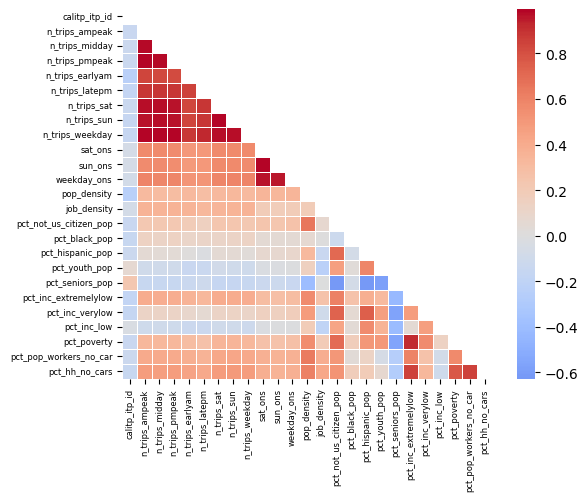

In [17]:
# Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype='bool')  
mask[np.triu_indices_from(mask)]=True

# heatmap
sns.heatmap(corr, 
            mask=mask, 
            cmap="coolwarm",
            square=True,
            linewidths=.5,
            center=0,
            xticklabels=True,
            yticklabels=True
           )

# changing the fontsize of yticks
plt.yticks(fontsize=6)
plt.xticks(fontsize=6)

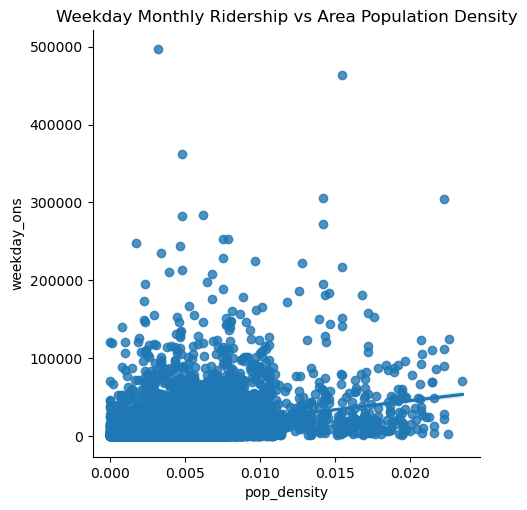

In [18]:
sns.lmplot(x="pop_density",y="weekday_ons", data=analysis_tbl).set(title="Weekday Monthly Ridership vs Area Population Density")

## scatterplots of highly correlated variables

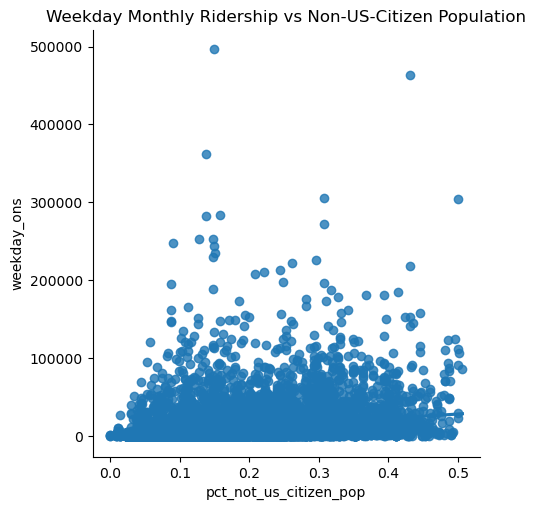

In [19]:
sns.lmplot(x="pct_not_us_citizen_pop",y="weekday_ons", data=analysis_tbl).set(title="Weekday Monthly Ridership vs Non-US-Citizen Population")

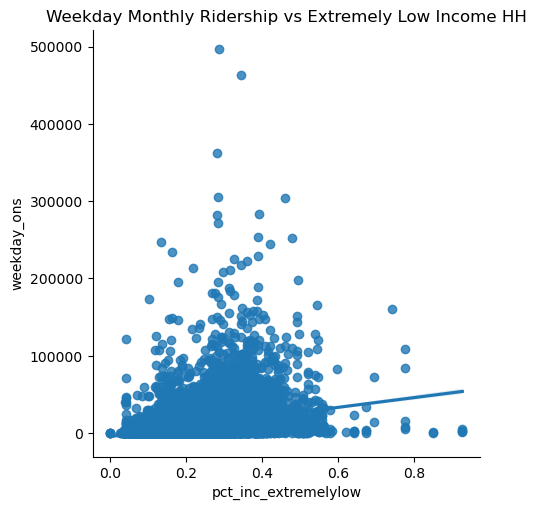

In [20]:
sns.lmplot(x="pct_inc_extremelylow",y="weekday_ons", data=analysis_tbl).set(title="Weekday Monthly Ridership vs Extremely Low Income HH")

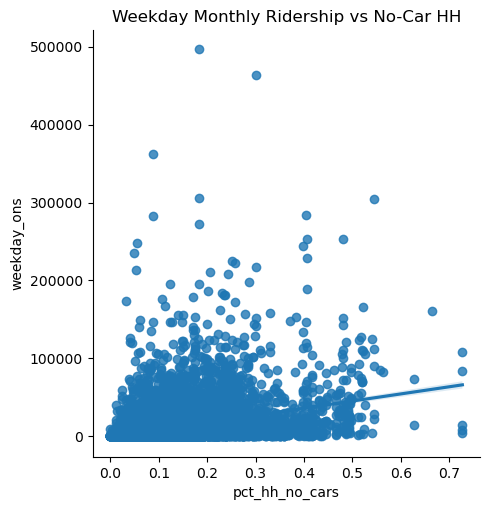

In [21]:
sns.lmplot(x="pct_hh_no_cars",y="weekday_ons", data=analysis_tbl).set(title="Weekday Monthly Ridership vs No-Car HH")

## VIF

In [22]:
# VIF function wrapper using Pandas - from Blake
def calc_vif(df:pd.DataFrame):
    '''
    Determine the variation inflaction factor for all columns in a dataframe.
    
    VIF calculation assumes a constant, so one is added as part of a wrapper function.
    https://github.com/statsmodels/statsmodels/issues/2376
    '''
    df_c = df.assign(const=1)
    vif = pd.Series([variance_inflation_factor(df_c.values, i) 
                                    for i in range(df_c.shape[1])],
                       index=df_c.columns)
    vif.drop(index=['const'], inplace=True)
    return(vif)

In [37]:
# make a regular df, drop nans
analysis_tbl_df = pd.DataFrame(analysis_tbl)
analysis_tbl_df = (analysis_tbl_df.dropna() >> select(-_["stop_name", "stop_id","geometry"]))

analysis_tbl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13723 entries, 0 to 13745
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calitp_itp_id           13723 non-null  int64  
 1   n_trips_ampeak          13723 non-null  float64
 2   n_trips_midday          13723 non-null  float64
 3   n_trips_pmpeak          13723 non-null  float64
 4   n_trips_earlyam         13723 non-null  float64
 5   n_trips_latepm          13723 non-null  float64
 6   n_trips_sat             13723 non-null  float64
 7   n_trips_sun             13723 non-null  float64
 8   n_trips_weekday         13723 non-null  float64
 9   sat_ons                 13723 non-null  float64
 10  sun_ons                 13723 non-null  float64
 11  weekday_ons             13723 non-null  float64
 12  pop_density             13723 non-null  float64
 13  job_density             13723 non-null  float64
 14  pct_not_us_citizen_pop  13723 non-null

In [38]:
calc_vif(analysis_tbl_df)

/opt/conda/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars


calitp_itp_id               1.283864
n_trips_ampeak                   inf
n_trips_midday                   inf
n_trips_pmpeak                   inf
n_trips_earlyam                  inf
n_trips_latepm                   inf
n_trips_sat               109.304653
n_trips_sun               101.181247
n_trips_weekday                  inf
sat_ons                    52.261737
sun_ons                    34.669252
weekday_ons                17.890569
pop_density                 2.549107
job_density                 1.471182
pct_not_us_citizen_pop      5.528736
pct_black_pop               1.490089
pct_hispanic_pop            3.735269
pct_youth_pop               2.789383
pct_seniors_pop             2.516275
pct_inc_extremelylow       11.850276
pct_inc_verylow             3.117282
pct_inc_low                 1.874334
pct_poverty                11.538822
pct_pop_workers_no_car      6.054722
pct_hh_no_cars             12.671865
dtype: float64